In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

da = pd.read_csv("data_for_lda.csv")


high_rating = da[da['stars_y'] >= 3.5] 
low_rating = da[da['stars_y'] <= 2]   

def create_dtm(dataframe):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(dataframe['tokens'])
    return dtm, vectorizer


def train_lda(dtm, n_topics=3):
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(dtm)
    return lda

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

high_dtm, high_vectorizer = create_dtm(high_rating)
high_lda = train_lda(high_dtm, n_topics=3) 
print("High-rate topics:")
print_top_words(high_lda, high_vectorizer.get_feature_names(), n_top_words=10) 


low_dtm, low_vectorizer = create_dtm(low_rating)
low_lda = train_lda(low_dtm, n_topics=3)  
print("Low-rate topics:")
print_top_words(low_lda, low_vectorizer.get_feature_names(), n_top_words=10)

High-rate topics:
Topic #0: food great service place good mexican nt time restaurant love
Topic #1: tacos taco good nt place food chicken mexican fresh like
Topic #2: nt food ordered like good order came time table got

Low-rate topics:
Topic #0: nt chipotle time food location burrito order line like chicken
Topic #1: order nt chipotle food time line service rice customer bowl
Topic #2: chipotle food location staff time service nt good like place



In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

da['compound'] = [analyzer.polarity_scores(text)['compound'] for text in da['cleaned_text']]

high_topic_results = high_lda.transform(high_dtm)  
low_topic_results = low_lda.transform(low_dtm)   


high_rate = da[da['stars_y'] >= 3.5].copy()  
low_rate = da[da['stars_y'] <= 2].copy() 

high_rate['high_topic'] = high_lda.transform(high_dtm).argmax(axis=1)
low_rate['low_topic'] = low_lda.transform(low_dtm).argmax(axis=1)

da.loc[high_rate.index, 'high_topic'] = high_rate['high_topic']
da.loc[low_rate.index, 'low_topic'] = low_rate['low_topic']

high_topic_sentiment = da.loc[da['stars_y'] >= 4].groupby('high_topic')['compound'].mean()
low_topic_sentiment = da.loc[da['stars_y'] <= 3].groupby('low_topic')['compound'].mean()

print("sentiment score for high rate:\n", high_topic_sentiment)
print("sentiment score for low rate:\n", low_topic_sentiment)


sentiment score for high rate:
 high_topic
0.0    0.836490
1.0    0.814353
2.0    0.513223
Name: compound, dtype: float64
sentiment score for low rate:
 low_topic
0.0    0.031043
1.0   -0.218861
2.0    0.227659
Name: compound, dtype: float64


In [4]:
high_rate_sentiment_df = da[da['stars_y'] >= 4][['high_topic', 'compound']].copy()
high_rate_sentiment_df['average_sentiment'] = high_rate_sentiment_df.groupby('high_topic')['compound'].transform('mean')

low_rate_sentiment_df = da[da['stars_y'] <= 3][['low_topic', 'compound']].copy()
low_rate_sentiment_df['average_sentiment'] = low_rate_sentiment_df.groupby('low_topic')['compound'].transform('mean')

high_rate_sentiment_df.to_csv('high_rate_sentiment.csv', index=False)
low_rate_sentiment_df.to_csv('low_rate_sentiment.csv', index=False)


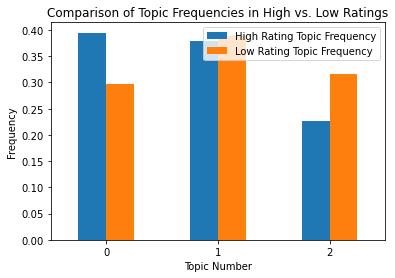

In [5]:
high_topic_freq = high_rate['high_topic'].value_counts(normalize=True)  
low_topic_freq = low_rate['low_topic'].value_counts(normalize=True)
topic_freq_df = pd.DataFrame({'High Rating Topic Frequency': high_topic_freq,
                              'Low Rating Topic Frequency': low_topic_freq}).reset_index()

import matplotlib.pyplot as plt

topic_freq_df.plot(x='index', y=['High Rating Topic Frequency', 'Low Rating Topic Frequency'], kind='bar')
plt.title('Comparison of Topic Frequencies in High vs. Low Ratings')
plt.xlabel('Topic Number')
plt.ylabel('Frequency')
plt.xticks(rotation=0) 
plt.show()


Topic 0: High-rating mean sentiment = 0.820435138764547, Low-rating mean sentiment = 0.031042519685039363
t-statistic: 26.551599465721047, p-value: 1.1772925833500608e-149
Topic 1: High-rating mean sentiment = 0.798762523320897, Low-rating mean sentiment = -0.21886084337349393
t-statistic: 36.72917584704622, p-value: 8.91958290150068e-275
Topic 2: High-rating mean sentiment = 0.4677044965786898, Low-rating mean sentiment = 0.22765925925925937
t-statistic: 4.191066251825557, p-value: 2.8221016283731057e-05


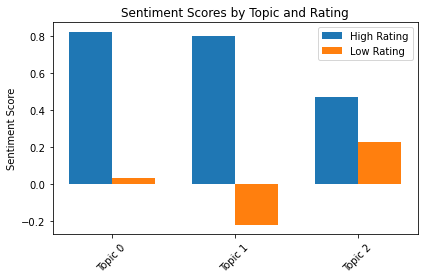

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

cross_topics = set(high_rate['high_topic']) & set(low_rate['low_topic'])

high_topic_sentiment = da.loc[da['high_topic'].isin(cross_topics)].groupby('high_topic')['compound'].mean()
low_topic_sentiment = da.loc[da['low_topic'].isin(cross_topics)].groupby('low_topic')['compound'].mean()

for topic in cross_topics:
    high_mean = high_topic_sentiment[topic]
    low_mean = low_topic_sentiment[topic]
    print(f"Topic {topic}: High-rating mean sentiment = {high_mean}, Low-rating mean sentiment = {low_mean}")

    high_sentiments = da.loc[da['high_topic'] == topic, 'compound']
    low_sentiments = da.loc[da['low_topic'] == topic, 'compound']
    t_stat, p_value = ttest_ind(high_sentiments, low_sentiments)
    print(f"t-statistic: {t_stat}, p-value: {p_value}")

topic_labels = [f"Topic {topic}" for topic in cross_topics]
high_means = [high_topic_sentiment[topic] for topic in cross_topics]
low_means = [low_topic_sentiment[topic] for topic in cross_topics]

x = np.arange(len(cross_topics))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, high_means, width, label='High Rating')
rects2 = ax.bar(x + width/2, low_means, width, label='Low Rating')

ax.set_ylabel('Sentiment Score')
ax.set_title('Sentiment Scores by Topic and Rating')
ax.set_xticks(x)
ax.set_xticklabels(topic_labels)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


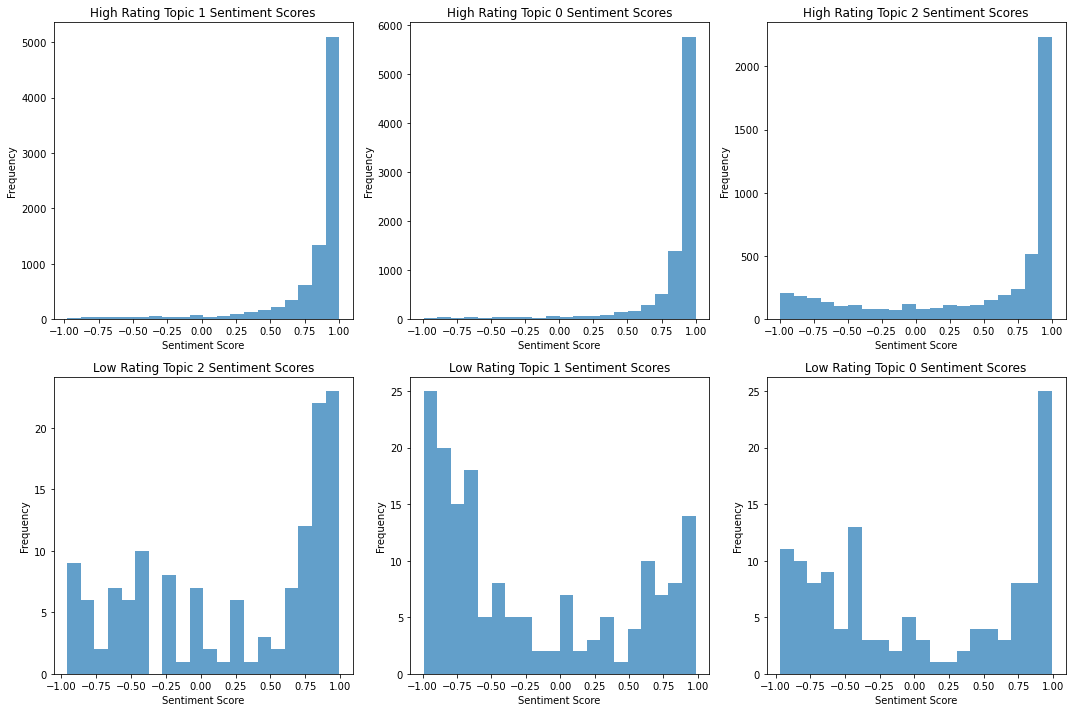

In [7]:
import numpy as np
import matplotlib.pyplot as plt

unique_high_topics = da['high_topic'].dropna().unique()
unique_low_topics = da['low_topic'].dropna().unique()

fig, ax = plt.subplots(2, max(len(unique_high_topics), len(unique_low_topics)), figsize=(15, 10))

if len(unique_high_topics) == 1:
    ax = np.array([[ax[0]], [ax[1]]])

for i, topic in enumerate(unique_high_topics):
    scores = da.loc[da['high_topic'] == topic, 'compound']
    ax[0, i].hist(scores, bins=20, alpha=0.7)
    ax[0, i].set_title(f'High Rating Topic {int(topic)} Sentiment Scores')
    ax[0, i].set_xlabel('Sentiment Score')
    ax[0, i].set_ylabel('Frequency')

for i, topic in enumerate(unique_low_topics):
    scores = da.loc[da['low_topic'] == topic, 'compound']
    ax[1, i].hist(scores, bins=20, alpha=0.7)
    ax[1, i].set_title(f'Low Rating Topic {int(topic)} Sentiment Scores')
    ax[1, i].set_xlabel('Sentiment Score')
    ax[1, i].set_ylabel('Frequency')

for i in range(len(unique_high_topics), ax.shape[1]):
    fig.delaxes(ax[0, i])
for i in range(len(unique_low_topics), ax.shape[1]):
    fig.delaxes(ax[1, i])

plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import ast

df = pd.read_csv('data_for_LDA.csv')
df['tokens'] = df['tokens'].apply(ast.literal_eval)

high_rating_df = df[df['stars_y'] >= 3].copy()
low_rating_df = df[df['stars_y'] <= 2.5].copy()

def create_bigrams(tokens):
    phrases = Phrases(tokens, min_count=5, threshold=10)
    bigram = Phraser(phrases)
    return [bigram[token_list] for token_list in tokens]

high_rating_df['bigrams'] = create_bigrams(high_rating_df['tokens'])
low_rating_df['bigrams'] = create_bigrams(low_rating_df['tokens'])

high_rating_df['bigrams_str'] = high_rating_df['bigrams'].apply(lambda x: ' '.join(x))
low_rating_df['bigrams_str'] = low_rating_df['bigrams'].apply(lambda x: ' '.join(x))

def train_lda(data, n_topics):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(data['bigrams_str'])
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(dtm)
    return lda, vectorizer.get_feature_names(), vectorizer

high_lda, high_feature_names, high_vectorizer = train_lda(high_rating_df, n_topics=3)
low_lda, low_feature_names, low_vectorizer = train_lda(low_rating_df, n_topics=3)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("High-rating topics:")
print_top_words(high_lda, high_feature_names, 10)

print("\nLow-rating topics:")
print_top_words(low_lda, low_feature_names, 10)

high_topic_results = high_lda.transform(high_vectorizer.transform(high_rating_df['bigrams_str']))
low_topic_results = low_lda.transform(low_vectorizer.transform(low_rating_df['bigrams_str']))

high_rating_df['high_topic'] = high_topic_results.argmax(axis=1)
low_rating_df['low_topic'] = low_topic_results.argmax(axis=1)

sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    return sia.polarity_scores(text)['compound']

high_rating_df['sentiment_score'] = high_rating_df['bigrams_str'].apply(get_sentiment_scores)
low_rating_df['sentiment_score'] = low_rating_df['bigrams_str'].apply(get_sentiment_scores)

high_topic_sentiment = high_rating_df.groupby('high_topic')['sentiment_score'].mean()
low_topic_sentiment = low_rating_df.groupby('low_topic')['sentiment_score'].mean()

print("\nAverage sentiment score for high-rating topics:")
print(high_topic_sentiment)
print("\nAverage sentiment score for low-rating topics:")
print(low_topic_sentiment)




High-rating topics:
Topic #0: food nt place service good order time ordered came table
Topic #1: food tacos place great good mexican best love service taco
Topic #2: good ordered nt great tacos food chicken salsa got really

Low-rating topics:
Topic #0: order food nt ordered got chipotle chips staff line time
Topic #1: food good chipotle nt service place great location really like
Topic #2: chipotle food location nt time line order chicken bowl like

Average sentiment score for high-rating topics:
high_topic
0    0.393525
1    0.826979
2    0.842291
Name: sentiment_score, dtype: float64

Average sentiment score for low-rating topics:
low_topic
0    0.141771
1    0.667018
2   -0.077669
Name: sentiment_score, dtype: float64

Perplexity of high-rating LDA model: 2113.356200274059
Perplexity of low-rating LDA model: 1326.3922672500007


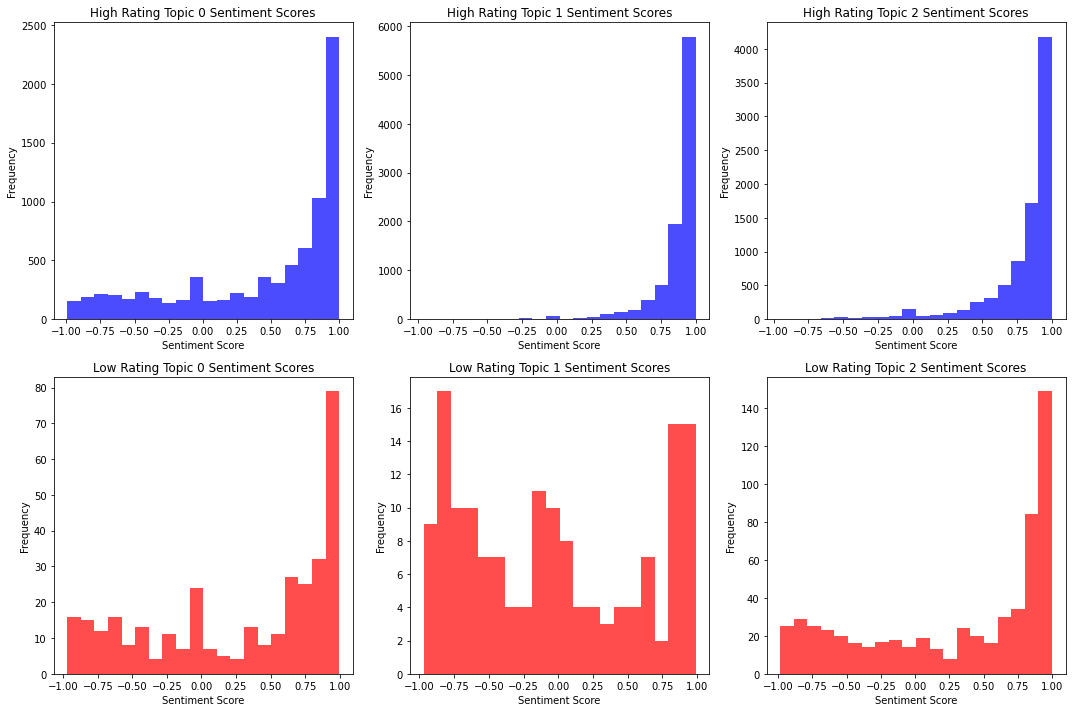

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  

for i in range(3):
    high_scores = high_rating_df[high_rating_df['high_topic'] == i]['sentiment_score']
    axs[0, i].hist(high_scores, bins=20, color='blue', alpha=0.7)
    axs[0, i].set_title(f'High Rating Topic {i} Sentiment Scores')
    axs[0, i].set_xlabel('Sentiment Score')
    axs[0, i].set_ylabel('Frequency')

    low_scores = low_rating_df[low_rating_df['low_topic'] == i]['sentiment_score']
    axs[1, i].hist(low_scores, bins=20, color='red', alpha=0.7)
    axs[1, i].set_title(f'Low Rating Topic {i} Sentiment Scores')
    axs[1, i].set_xlabel('Sentiment Score')
    axs[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import ast

df = pd.read_csv('data_for_LDA.csv')
df['tokens'] = df['tokens'].apply(ast.literal_eval)

high_rating_df = df[df['stars_y'] >= 3].copy()
low_rating_df = df[df['stars_y'] <= 2.5].copy()

def create_bigrams_trigrams(tokens):
    bigram_phrases = Phrases(tokens, min_count=5, threshold=10)
    bigram = Phraser(bigram_phrases)
    bigrams = [bigram[token_list] for token_list in tokens]
    
    trigram_phrases = Phrases(bigrams, min_count=5, threshold=10)
    trigram = Phraser(trigram_phrases)
    trigrams = [trigram[bigram_tokens] for bigram_tokens in bigrams]
    
    return trigrams

high_rating_df['trigrams'] = create_bigrams_trigrams(high_rating_df['tokens'])
low_rating_df['trigrams'] = create_bigrams_trigrams(low_rating_df['tokens'])

high_rating_df['trigrams_str'] = high_rating_df['trigrams'].apply(lambda x: ' '.join(x))
low_rating_df['trigrams_str'] = low_rating_df['trigrams'].apply(lambda x: ' '.join(x))

def train_lda(data, n_topics):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(data['trigrams_str'])
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(dtm)
    return lda, vectorizer.get_feature_names(), vectorizer

high_lda, high_feature_names, high_vectorizer = train_lda(high_rating_df, n_topics=3)
low_lda, low_feature_names, low_vectorizer = train_lda(low_rating_df, n_topics=3)

high_topic_results = high_lda.transform(high_vectorizer.transform(high_rating_df['trigrams_str']))
low_topic_results = low_lda.transform(low_vectorizer.transform(low_rating_df['trigrams_str']))

high_rating_df['high_topic'] = high_topic_results.argmax(axis=1)
low_rating_df['low_topic'] = low_topic_results.argmax(axis=1)

sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    return sia.polarity_scores(text)['compound']

high_rating_df['sentiment_score'] = high_rating_df['trigrams_str'].apply(get_sentiment_scores)
low_rating_df['sentiment_score'] = low_rating_df['trigrams_str'].apply(get_sentiment_scores)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print("High-rating topics:")
print_top_words(high_lda, high_feature_names, 10)

print("\nLow-rating topics:")
print_top_words(low_lda, low_feature_names, 10)

high_topic_sentiment = high_rating_df.groupby('high_topic')['sentiment_score'].mean()
low_topic_sentiment = low_rating_df.groupby('low_topic')['sentiment_score'].mean()

print("\nAverage sentiment score for high-rating topics:")
print(high_topic_sentiment)
print("\nAverage sentiment score for low-rating topics:")
print(low_topic_sentiment)


High-rating topics:
Topic #0:
nt food ordered good place order got like came service
Topic #1:
great food good place service delicious amazing love tacos drinks
Topic #2:
tacos place good food taco great delicious fresh best nt

Low-rating topics:
Topic #0:
food chipotle nt staff service location time really like good
Topic #1:
chipotle location nt burrito bowl food rice like chicken guacamole
Topic #2:
food nt order chipotle location good place service got great

Average sentiment score for high-rating topics:
high_topic
0    0.444470
1    0.863494
2    0.794351
Name: sentiment_score, dtype: float64

Average sentiment score for low-rating topics:
low_topic
0    0.283483
1   -0.040270
2    0.303334
Name: sentiment_score, dtype: float64


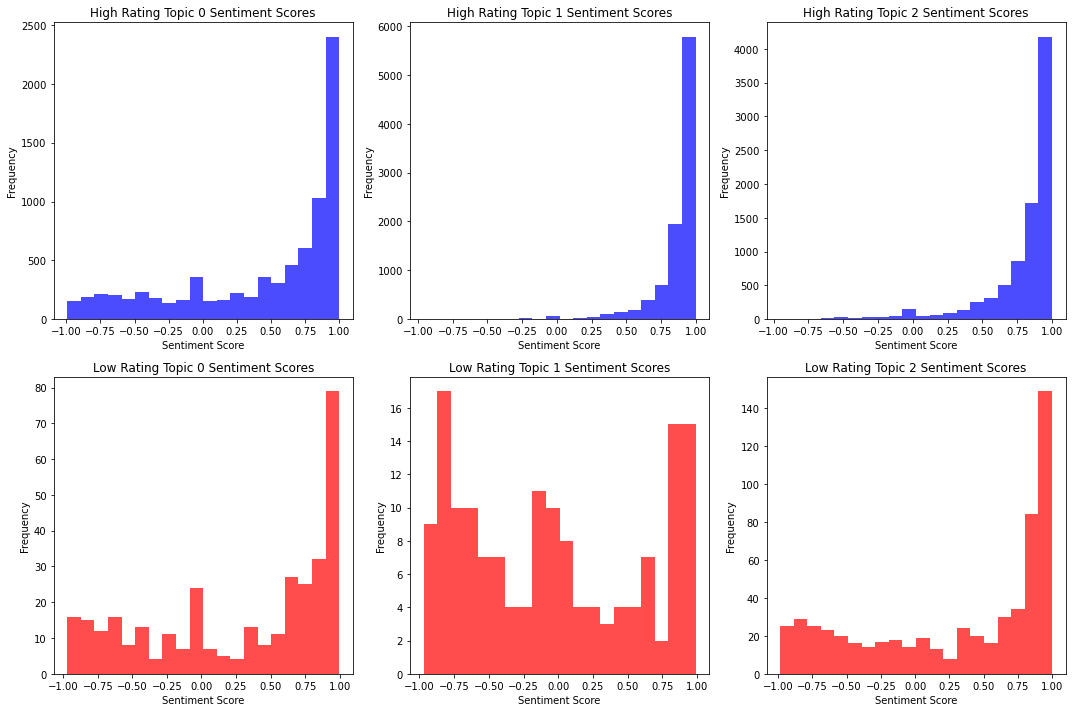

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10)) 

for i in range(3):
    high_scores = high_rating_df[high_rating_df['high_topic'] == i]['sentiment_score']
    axs[0, i].hist(high_scores, bins=20, color='blue', alpha=0.7)
    axs[0, i].set_title(f'High Rating Topic {i} Sentiment Scores')
    axs[0, i].set_xlabel('Sentiment Score')
    axs[0, i].set_ylabel('Frequency')


    low_scores = low_rating_df[low_rating_df['low_topic'] == i]['sentiment_score']
    axs[1, i].hist(low_scores, bins=20, color='red', alpha=0.7)
    axs[1, i].set_title(f'Low Rating Topic {i} Sentiment Scores')
    axs[1, i].set_xlabel('Sentiment Score')
    axs[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()